In [1]:
from scipy.io import savemat
import scipy.io     # used to load .mat data

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import seaborn as sns

from models import TandemNet, MLP ,cVAE, cGAN, INN, cVAE_new, cVAE_GSNN
from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid, cVAE_tandem, cVAE_GSNN1
from utils import evaluate_tandem_minmax_accuracy, evaluate_forward_minmax_dataset, evaluate_forward_minmax, evaluate_vae_GSNN_minmax_inverse, evaluate_gan_minmax_inverse, evaluate_inn_minmax_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred, plt_abs_err, plt_hist_struc, plot_struc_raw_pred
from datasets import get_dataloaders, SiliconColor
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('forward_model')




In [69]:
# choose 10 random CIE
# compare the results of inverse design: tandem, VAE, GAN

def insert_xyY(xyY, B):

    a = len(B)
    for i in range(a):
        xyY = np.insert(xyY, B[i], [0, 1, 1], axis=0)

    return xyY

# load tandem:

filepath_tandem = "./data_predicted/param_tandem_pred.mat"
temp = scipy.io.loadmat(filepath_tandem)
insert_tandem = list(list(temp.items())[7][1][0,:])
filepath_tandem ="./data_predicted/xyY/xyY_param_tandem_pred.mat"
temp = scipy.io.loadmat(filepath_tandem)
cie_raw = np.array(list(temp.items())[7][1])
xyY_tandem = insert_xyY(np.array(list(temp.items())[7][1]), insert_tandem)


# load vae:
filepath_vae = "./data_predicted/param_vae_hybrid_GSNN1_1_pred.mat"
temp = scipy.io.loadmat(filepath_vae)
insert_vae = list(list(temp.items())[7][1][0,:])
filepath_vae = "./data_predicted/xyY/xyY_param_vae_hybrid_GSNN1_1_pred.mat"
temp = scipy.io.loadmat(filepath_vae)
xyY_vae = insert_xyY(np.array(list(temp.items())[7][1]), insert_vae)

# load GAN:
filepath_gan = "./data_predicted/param_cgan_pred.mat"
temp = scipy.io.loadmat(filepath_gan)
insert_gan = list(list(temp.items())[7][1][0,:])
filepath_gan = "./data_predicted/xyY/xyY_param_cgan_pred.mat"
temp = scipy.io.loadmat(filepath_gan)
xyY_gan = insert_xyY(np.array(list(temp.items())[7][1]), insert_gan)

# load the original CIE: 
filepath_cie = "./data_predicted/param_cgan_pred_all.mat"
temp = scipy.io.loadmat(filepath_cie)
xyY_original = np.array(list(temp.items())[6][1])


print(xyY_tandem[300,:])

[ 0.15522022  0.12872455  0.04064782]


In [70]:
# convert xyY to RGB

M_RGB_TO_XYZ = np.array([
    [0.5767309, 0.1855540  ,0.1881852],
    [0.2973769 , 0.6273491  ,0.0752741],
    [0.0270343,  0.0706872  ,0.9911085]])

M_sRGB_TO_XYZ = np.array([
    [ 0.4124564 , 0.3575761  ,0.1804375],
    [0.2126729 , 0.7151522  ,0.0721750],
    [0.0193339 , 0.1191920 , 0.9503041]])

M_XYZ_TO_sRGB = np.linalg.inv(M_sRGB_TO_XYZ)    
M_XYZ_TO_RGB = np.linalg.inv(M_RGB_TO_XYZ)   
print(M_XYZ_TO_sRGB)
print(M_XYZ_TO_RGB)

def xyY_to_XYZ(xyY):
    # http://www.brucelindbloom.com/index.html?Eqn_xyY_to_XYZ.html
    a = len(xyY)

    XYZ = np.zeros([a, 3])
    for i in range(a):
        if xyY[i,1] ==0:
            print(i)
        XYZ[i,0] = xyY[i,0]*xyY[i,2]/xyY[i,1]
        XYZ[i,1] = xyY[i,2]
        XYZ[i,2] = (1-xyY[i,0]-xyY[i,1])*xyY[i,2]/xyY[i,1]
    
    return XYZ

def xyY_to_RGB(xyY):

    return np.dot(xyY_to_XYZ(xyY), M_XYZ_TO_RGB)

xyz_original = xyY_to_XYZ(xyY_original)
xyz_tandem = xyY_to_XYZ(xyY_tandem)
xyz_vae = xyY_to_XYZ(xyY_vae)
xyz_gan = xyY_to_XYZ(xyY_gan)

rgb_original = xyY_to_RGB(xyY_original)
rgb_tandem = xyY_to_RGB(xyY_tandem)
rgb_vae = xyY_to_RGB(xyY_vae)
rgb_gan = xyY_to_RGB(xyY_gan)




[[ 3.24045484 -1.53713885 -0.49853155]
 [-0.96926639  1.87601093  0.04155608]
 [ 0.05564342 -0.20402585  1.05722516]]
[[ 2.04136908 -0.56494656 -0.34469446]
 [-0.96926614  1.87601087  0.04155601]
 [ 0.01344729 -0.11838968  1.01540961]]


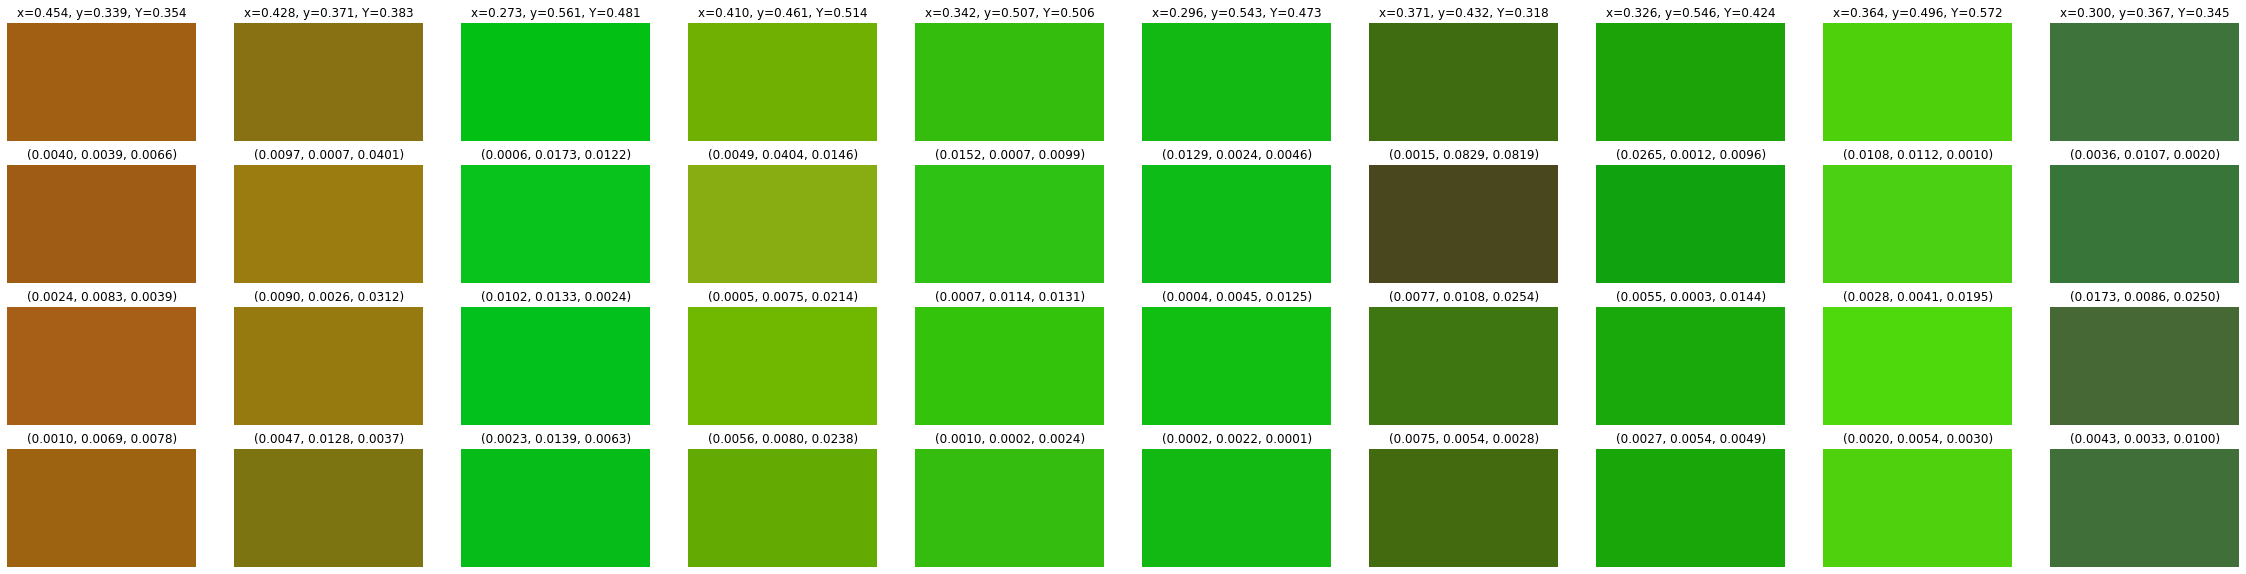

In [110]:
M = len(xyY_original)
N = 10

row_cie = []
i = 0

while len(row_cie)<N:
    m = np.random.randint(M)
    
    if xyY_original[m,2] < 0.3:

        continue
    if m in row_cie:
        continue
    row_cie.append(m)

    if min(rgb_original[row_cie[i],:])>0:
            i+=1
    else:
        del row_cie[-1]



fig, axs = plt.subplots(4, N, figsize=[40,10])
x = [0,0.5,1]
y = [1,1,1]

abs_tandem = abs(xyY_tandem[row_cie,:]-xyY_original[row_cie,:])
abs_vae = abs(xyY_vae[row_cie,:]-xyY_original[row_cie,:])
abs_gan = abs(xyY_gan[row_cie,:]-xyY_original[row_cie,:])

for i in range(N):
    if min(rgb_original[row_cie[i],:])<=0:
        continue

    axs[0,i].plot(x, y, color=rgb_original[row_cie[i],:], linewidth=300)
    axs[0,i].set_title('x={:.3f}, y={:.3f}, Y={:.3f}'.format(xyY_original[row_cie[i],0],xyY_original[row_cie[i],1],xyY_original[row_cie[i],2]))
    axs[0,i].axis('off')

    if min(rgb_tandem[row_cie[i],:])<0:
        axs[1,i].plot(x, y, color='r',linewidth=1)
    else:
        axs[1,i].plot(x, y, color=rgb_tandem[row_cie[i],:], linewidth=300)

    axs[1,i].set_title('({:.4f}, {:.4f}, {:.4f})'.format(abs_tandem[i,0],abs_tandem[i,1],abs_tandem[i,2]))
    axs[1,i].axis('off')

    if min(rgb_vae[row_cie[i],:])<0:
        axs[1,i].plot(x, y, color='r', linewidth=1)
    else:
        axs[2,i].plot(x, y, color=rgb_vae[row_cie[i],:], linewidth=300)
    axs[2,i].set_title('({:.4f}, {:.4f}, {:.4f})'.format(abs_vae[i,0],abs_vae[i,1],abs_vae[i,2]))
    axs[2,i].axis('off')

    if min(rgb_gan[row_cie[i],:])<0:
        axs[1,i].plot(x, y, color='r', linewidth=1)
    else:
        axs[3,i].plot(x, y, color=rgb_gan[row_cie[i],:], linewidth=300)
    axs[3,i].set_title('({:.4f}, {:.4f}, {:.4f})'.format(abs_gan[i,0],abs_gan[i,1],abs_gan[i,2]))
    axs[3,i].axis('off')





In [38]:
row_cie


[540, 233, 148, 607, 425, 220, 1289, 537, 136, 1338]

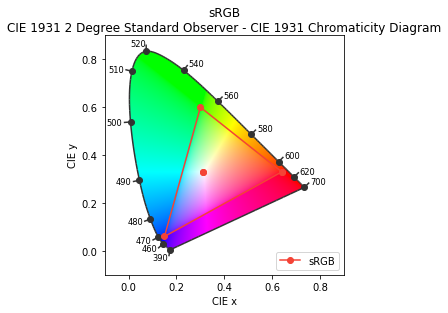

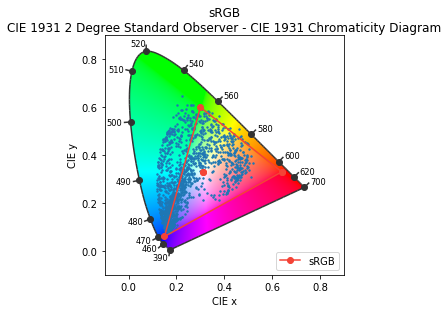

In [212]:
import colour
from colour.plotting import plot_chromaticity_diagram_CIE1931, plot_multi_colour_swatches
from colour.plotting.models import plot_RGB_colourspaces_in_chromaticity_diagram
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

fig, ax = plot_RGB_colourspaces_in_chromaticity_diagram(['sRGB'], fig_size=[40, 40])
# ax.scatter(features[:,0], features[:,1], c=model.labels_.astype(float), s=0.01)
ax.scatter(xyY_original[:,0],xyY_original[:,1], s=2)

fig

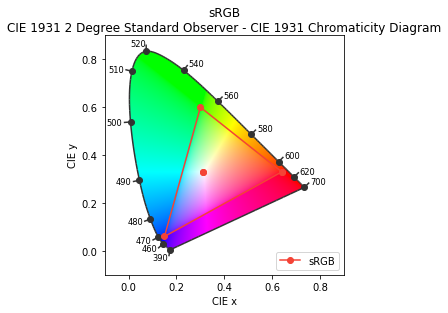

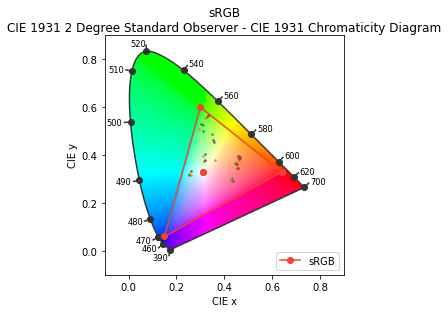

In [25]:
import colour
from colour.plotting import plot_chromaticity_diagram_CIE1931, ColourSwatch
from colour.plotting.models import plot_RGB_colourspaces_in_chromaticity_diagram
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution

# https://colour.readthedocs.io/en/v0.3.16_a/generated/colour.RGB_COLOURSPACES.html?highlight=colour.plotting.filter_RGB_colourspaces()#colour.RGB_COLOURSPACES

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

fig, ax = plot_RGB_colourspaces_in_chromaticity_diagram(['sRGB'])
# ax.scatter(features[:,0], features[:,1], c=model.labels_.astype(float), s=0.01)
ax.scatter(xyY_original[row_cie,0],xyY_original[row_cie,1], s=2)
ax.scatter(xyY_tandem[row_cie,0],xyY_tandem[row_cie,1], s=2)
ax.scatter(xyY_vae[row_cie,0],xyY_vae[row_cie,1], s=2)
ax.scatter(xyY_gan[row_cie,0],xyY_gan[row_cie,1], s=2)

fig

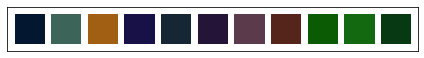

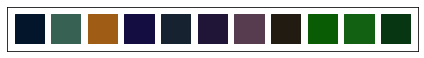

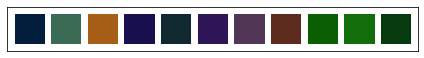

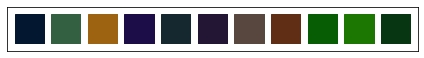

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f51971e7610>)

In [230]:
plot_multi_colour_swatches(rgb_original[row_cie,:], width = 4, spacing=1, height = 4, fig_size = [40,20])
plot_multi_colour_swatches(rgb_tandem[row_cie,:], width = 4, spacing=1, height = 4, fig_size = [40,20])
plot_multi_colour_swatches(rgb_vae[row_cie,:], width = 4, spacing=1, height = 4, fig_size = [40,20])
plot_multi_colour_swatches(rgb_gan[row_cie,:], width = 4, spacing=1, height = 4, fig_size = [40,20])

# Check one to many mapping 

In [54]:
# define some necessary functions for the predictions
def struc_check(structure):
    if np.sum(abs(structure)-structure)>0:  # if get negative parameters, then wrong structure
        return 0
    else:
        struc = np.reshape(structure, (-1, 4));
        N = np.shape(struc)[0]
        #print(struc)
        for i in range(N):
            if (struc[i,1]+struc[i,3]>=struc[i,2]):  # if gap+diameter >= period, then wrong structure
                return 0;
            
        return 1;

def struc_remove_1(param_pred):
    M = np.shape(param_pred)[0]
    B = []
    print(M)
    for i in range(M):
        if struc_check(param_pred[i,:])==0:
            B.append(i)
            print(i)
    
    return B

def struc_remove_2(param_pred):
    # remove the structure that is not inside the parameter range space. 
    M = np.shape(param_pred)[0]
    B = []
    for i in range(M):
        if (param_pred[i,3]>=160)|(param_pred[i,3]<=80)|(param_pred[i,0]>=200)|(param_pred[i,0]<=30)|(param_pred[i,1]>=320)|(param_pred[i,1]<=160)|(param_pred[i,2]>=700)|(param_pred[i,2]<=30):
            B.append(i)
            #print(i)
    
    return B
    
def plt_hist_struc1(param, labels):
    xlim = [[0, 210], [150, 330], [280, 720], [75, 165]]
    plt.figure(figsize = [20, 3])
    plt.subplot(1, 4,1)
    plt.hist(param[:,0], bins=20, histtype='step', label=labels)
    plt.title('Height histogram')
    plt.xlabel('Height/(nm)')
    plt.ylabel('Count')
    plt.xlim(xlim[0])
    plt.legend()
    
    plt.subplot(1, 4,2)
    plt.hist(param[:,1], bins=20, histtype='step', label=labels)
    plt.title('Gap histogram')
    plt.xlabel('Gap/(nm)')
    plt.xlim(xlim[1])
    
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.hist(param[:,2], bins=20, histtype='step', label=labels)
    plt.title('Period histogram')
    plt.xlabel('Period/(nm)')
    plt.ylabel('Count')
    plt.xlim(xlim[2])
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.hist(param[:,3], bins=20, histtype='step', label=labels)
    plt.title('Diameter histogram')
    plt.xlabel('Diamater/(nm)')
    plt.ylabel('Count')
    plt.legend()
    plt.xlim(xlim[3])
    plt.show()



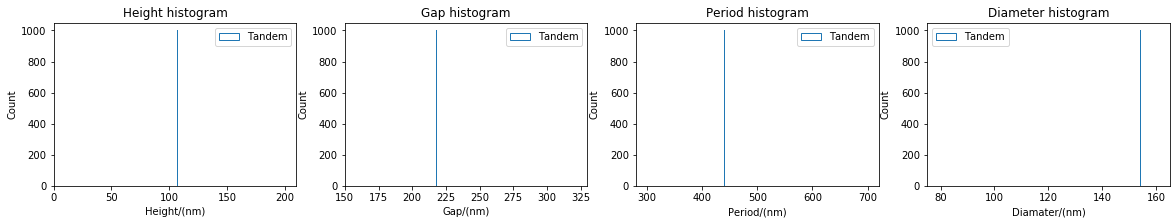

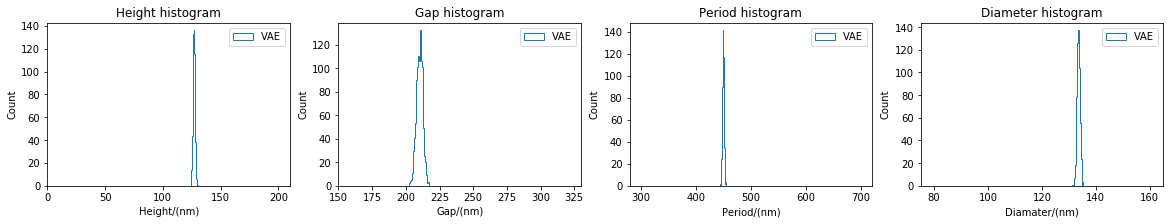

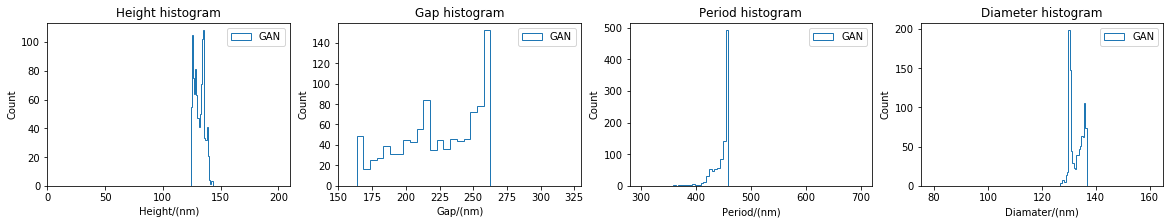

In [52]:
# check one-to-many mapping 


train_loader, val_loader, test_loader_gan = get_dataloaders('gan')
train_loader, val_loader, test_loader_vae = get_dataloaders('vae_hybrid')

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained_evaluate_1.pth')['model_state_dict'])
inverse_model = MLP(3, 4).to(DEVICE)

tandem_model = TandemNet(forward_model, inverse_model)
tandem_model.load_state_dict(torch.load('./models/tandem_net_trained_1.pth')['model_state_dict'])

configs = get_configs('vae_hybrid')
vae_model = cVAE_GSNN1(configs['input_dim'], configs['latent_dim']).to(DEVICE)
model = cVAE_hybrid(forward_model, vae_model)
model.load_state_dict(torch.load('./models/vae_hybrid_GSNN1_1_trained.pth')['model_state_dict'])

configs = get_configs('gan')

gan_model = cGAN(configs['input_dim'], configs['output_dim'], configs['noise_dim']).to(DEVICE)
gan_path = './models/cgan/cgan_noise_2_g_0.0005_d_0.0005_STEP_True_trained.pth'
gan_model.load_state_dict(torch.load(gan_path)['model_state_dict'])



M = 1000
T = 1338
param_tandem = np.zeros([M, 4])
param_gan = np.zeros([M, 4])
param_vae = np.zeros([M, 4])
for i in range(M):
    cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_accuracy(tandem_model, forward_model, test_loader.dataset, show=0)
    param_tandem[i, :] = param_pred[T, :]
    cie_raw, param_raw, cie_pred, param_pred = evaluate_gan_minmax_inverse(gan_model, forward_model, test_loader_gan.dataset, show=0)
    param_gan[i, :] = param_pred[T, :]
    cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_GSNN_minmax_inverse(model.vae_model, forward_model, test_loader_vae.dataset, show=0)
    param_vae[i, :] = param_pred[T, :]

plt_hist_struc1(param_tandem, 'Tandem')
plt_hist_struc1(param_vae, 'VAE')
plt_hist_struc1(param_gan, 'GAN')



In [41]:
print(param_raw[T,:])
print(cie_raw[T,:])
print(T)

[ 116.00000501  195.99999905  447.00000286  144.00000095]
[ 0.29166867  0.57114028  0.47202545]
1338


In [53]:
# save the predicted structures

mdic = {"param_pred": param_vae, "row":T, "cie_raw":cie_raw[T,:], "param_raw":param_raw[T,:]}
file_path_vae = "./data_predicted/param_vae_T_"+str(T)+"_pred.mat"
savemat(file_path_vae,mdic)

mdic = {"param_pred": param_gan, "row":T, "cie_raw":cie_raw[T,:], "param_raw":param_raw[T,:]}
file_path_gan = "./data_predicted/param_cgan_T_"+str(T)+"_pred.mat"
savemat(file_path_gan,mdic)


In [75]:
# load files and compare the predicted CIE VS target

from scipy.io import savemat
import scipy.io     # used to load .mat data
import colour
from colour.plotting import plot_chromaticity_diagram_CIE1931, ColourSwatch, plot_multi_colour_swatches
from colour.plotting.models import plot_RGB_colourspaces_in_chromaticity_diagram
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution


filepath_vae = "./data_predicted/param_vae_T_1338_pred.mat"
temp = scipy.io.loadmat(filepath_vae)
param_vae = np.array(list(temp.items())[6][1])
B_vae = struc_remove_1(param_vae)
param_vae = np.delete(param_vae, B_vae, 0)

filepath_vae ="./data_predicted/xyY/xyY_param_vae_T_1338_pred.mat"
temp = scipy.io.loadmat(filepath_vae)
xyY_pred_vae = np.array(list(temp.items())[3][1])
XYZ_pred_vae = xyY_to_XYZ(xyY_pred_vae)
RGB_pred_vae = xyY_to_RGB(xyY_pred_vae)

filepath_gan = "./data_predicted/param_cgan_T_1338_pred.mat"
temp = scipy.io.loadmat(filepath_gan)
param_gan = np.array(list(temp.items())[6][1])
B_gan = struc_remove_1(param_gan)
param_gan = np.delete(param_gan, B_gan, 0)

filepath_gan ="./data_predicted/xyY/xyY_param_cgan_T_1338_pred.mat"
temp = scipy.io.loadmat(filepath_gan)
xyY_pred_gan = np.array(list(temp.items())[3][1])
XYZ_pred_gan = xyY_to_XYZ(xyY_pred_gan)
RGB_pred_gan = xyY_to_RGB(xyY_pred_gan)


1
1
[[ 0.0360844   0.73591946  0.05165619]]


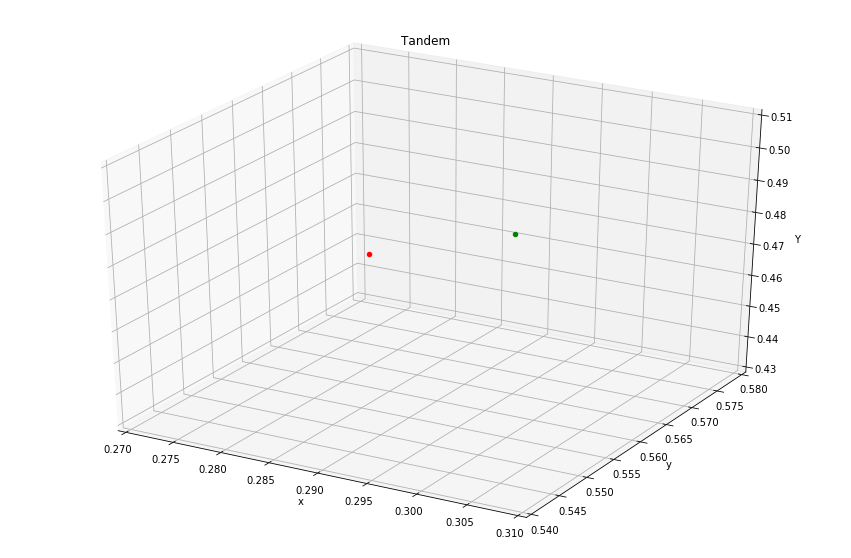

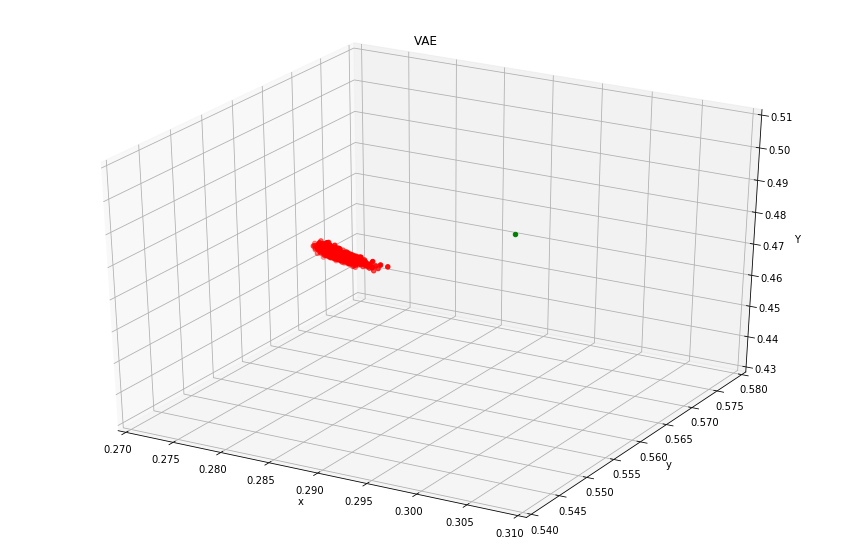

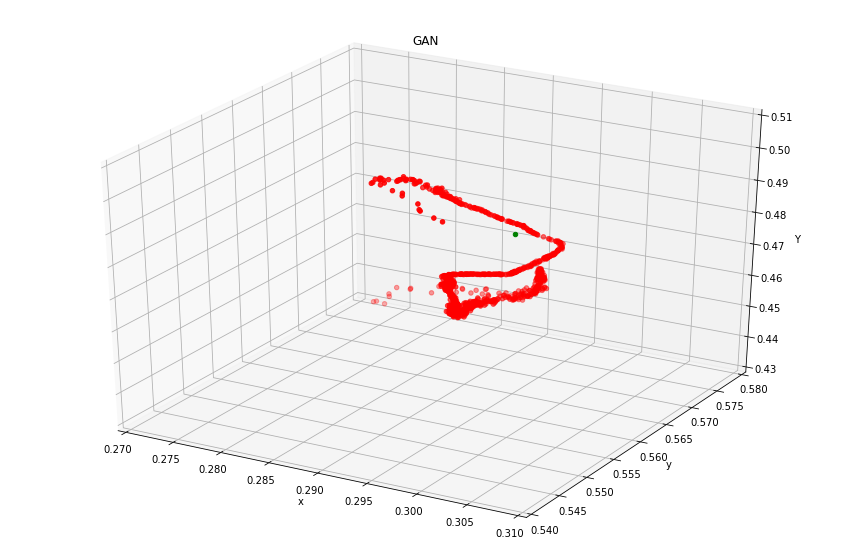

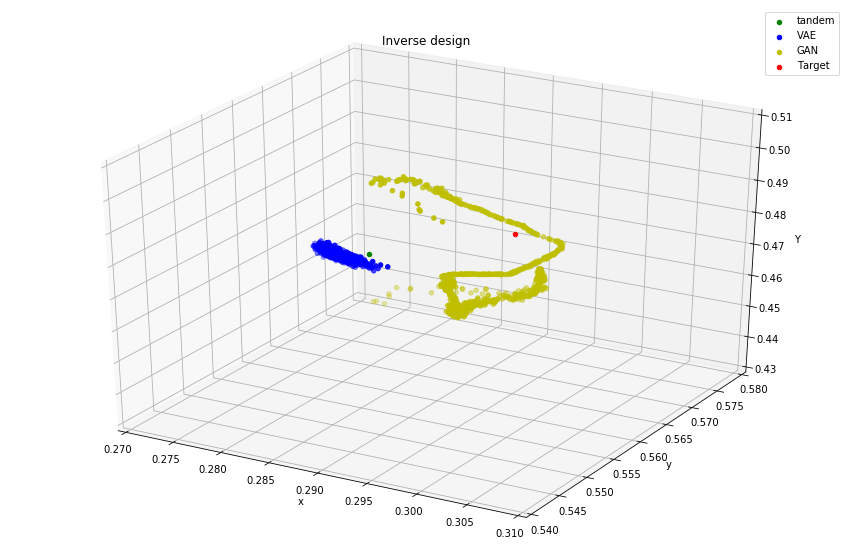

In [109]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(3)
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(15,10)
ax.scatter(xyY_tandem[T,0],xyY_tandem[T,1],xyY_tandem[T,2], c='r', marker='o')
ax.scatter(xyY_original[T,0],xyY_original[T,1],xyY_original[T,2], c='g', marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Y')
ax.set_xlim([0.27, 0.31])
ax.set_ylim([0.54, 0.58])
ax.set_zlim([0.43, 0.51])
ax.set_title('Tandem')
plt.show()

fig = plt.figure(1)
fig.set_size_inches(15,10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xyY_pred_vae[:,0], xyY_pred_vae[:,1], xyY_pred_vae[:,2],  c='r', marker='o')
ax.scatter(xyY_original[T,0],xyY_original[T,1],xyY_original[T,2], c='g', marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Y')
ax.set_title('VAE')
ax.set_xlim([0.27, 0.31])
ax.set_ylim([0.54, 0.58])
ax.set_zlim([0.43, 0.51])
plt.show()


fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(15,10)
ax.scatter(xyY_pred_gan[:,0], xyY_pred_gan[:,1], xyY_pred_gan[:,2],  c='r', marker='o')
ax.scatter(xyY_original[T,0],xyY_original[T,1],xyY_original[T,2], c='g', marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Y')
ax.set_title('GAN')
ax.set_xlim([0.27, 0.31])
ax.set_ylim([0.54, 0.58])
ax.set_zlim([0.43, 0.51])
plt.show()

fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(15,10)
ax.scatter(xyY_tandem[T,0],xyY_tandem[T,1],xyY_tandem[T,2], c='g', marker='o',label='tandem')
ax.scatter(xyY_pred_vae[:,0], xyY_pred_vae[:,1], xyY_pred_vae[:,2],  c='b', marker='o',label='VAE')
ax.scatter(xyY_pred_gan[:,0], xyY_pred_gan[:,1], xyY_pred_gan[:,2],  c='y', marker='o',label='GAN')
ax.scatter(xyY_original[T,0],xyY_original[T,1],xyY_original[T,2], c='r', marker='o',label='Target')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Y')
ax.set_title('Inverse design')
ax.set_xlim([0.27, 0.31])
ax.set_ylim([0.54, 0.58])
ax.set_zlim([0.43, 0.51])
plt.legend()
plt.show()



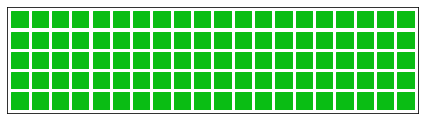

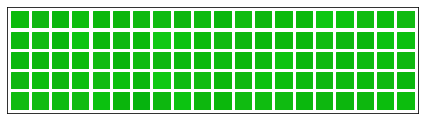

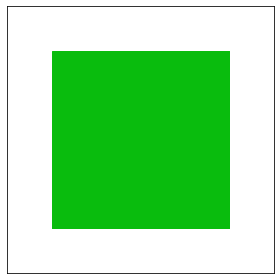

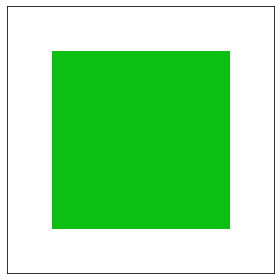

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f030a2454c0>)

In [99]:
# plot 100 CIE and compare

plot_multi_colour_swatches(RGB_pred_vae[np.random.randint(1000, size=100),:], width = 4, spacing=1, height = 4, columns=20)

plot_multi_colour_swatches(RGB_pred_gan[np.random.randint(1000, size=100),:], width = 4, spacing=1, height = 4, columns=20)
plot_multi_colour_swatches(rgb_original[T,:], width = 4, spacing=1, height = 4)

plot_multi_colour_swatches(rgb_tandem[T,:], width = 4, spacing=1, height = 4)

In [105]:
rmse_vae = np.sqrt(np.sum(np.average(np.square((xyY_pred_vae - xyY_original[T,:])),axis=0)))
ame_vae = np.average(np.abs(xyY_pred_vae - xyY_original[T,:]))
print(np.average(xyY_pred_vae, axis=0))
print(np.average(RGB_pred_vae, axis=0))
print(rmse_vae)
print(ame_vae)

rmse_gan = np.sqrt(np.sum(np.average(np.square((xyY_pred_gan - xyY_original[T,:])),axis=0)))
ame_gan = np.average(np.abs(xyY_pred_gan - xyY_original[T,:]))
print(np.average(xyY_pred_gan, axis=0))
print(np.average(RGB_pred_gan, axis=0))
print(rmse_gan)
print(ame_gan)

ame_tandem = np.average(abs(xyY_original[T,:] - xyY_tandem[T,:]))
rmse_tandem = np.sqrt(np.sum(np.average(np.square((xyY_original[T,:] - xyY_tandem[T,:])),axis=0)))
print(rmse_tandem)
print(ame_tandem)
print(xyY_tandem[T,:])
print(xyY_original[T,:])

print(rgb_original[T,:])

[ 0.28351141  0.55405435  0.47734705]
[ 0.03782734  0.74094682  0.07774699]
0.0197338496438
0.0101882669428
[ 0.29401497  0.56133161  0.47073013]
[ 0.04890497  0.72935546  0.05793307]
0.0181504051177
0.00766440730548
0.0136713557475
0.0117529360917
[ 0.28849397  0.55085887  0.48382814]
[ 0.29166867  0.57114028  0.47202545]
[ 0.0360844   0.73591946  0.05165619]
